# Day 05: OpenStreetMap

For this category, I wanted to extend the code from Day 3 (Polygons)

There are a variety of data sources I will use throughout these exercises, including:
* [Explorer Basemap](https://visibleearth.nasa.gov/images/147190/explorer-base-map): Joshua Stevens, NASA Earth Observatory
* [Comprehensive Global Administrative Zones (CGAZ)](https://www.geoboundaries.org/): geoBoundaries 4.0, William & Mary geoLab
* [Marine polys and lakes](https://www.naturalearthdata.com/): Natural Earth
* [World Cities](https://simplemaps.com/data/world-cities): Simple Maps

Data sources specific to a single day will be linked in the notebook where they appear.

## Configuration
Dependency imports and utility functions are in a separate `plotter.py` file in order to keep these notebooks clean.

In [1]:
import os
from geopy.geocoders import Nominatim
import random
import overpass
from shapely.geometry import shape
import matplotlib.pyplot as plt 
import geopandas as gpd
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Desired styling for matplotlib
from matplotlib import cycler
colors = cycler('color',["44aa98","ab4498","332389","86ccec","ddcc76","cd6477","882255", "117732"])
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['text.color'] = '212121'
plt.rcParams['xtick.color'] = '212121'
plt.rcParams['ytick.color'] = '212121'
plt.rcParams['font.family'] = 'sans serif'
plt.rcParams['axes.facecolor'] = 'None'
plt.rcParams['axes.edgecolor'] = 'dimgray'
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = 'x-small'
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'None'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['axes.labelsize'] = 'small'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'
plt.rc('axes', prop_cycle=colors)

# Query OSM
I want to find a generic way I can query building footprints from OSM for a city of interest. 

First, I will need to programmatically determine the coordinates of the city of interest. I want to be able to simply type in a string with the city name, so I will use the `geocoders` package. To make use of OSM data and to use a free provider without creating any acount, I will use **Nominatim**.

Second, I will want to query building footprints using the Overpass API for OpenStreetMap. I will have to assume a certain radius around the city coordinates from step one.

Third, I want to find query amenities using the Overpass API for OpenStreetMap using the same bounding box.

Last, I will plot the features!

In [3]:
# Choose a city of interest
# NOTE: Sometimes this retrieves a region boundary rather than a city location. 
# For example, 'Pavia, Italy' returns the comune of Pavia rather than the city of Pavia.
# In those cases, it is better to include a zip code, e.g., 'Pavia, 27100, Italy'
city = "Batam, Indonesia"

# Arrange geolocator
geolocator = Nominatim(user_agent="30daymapchallenge", timeout=100)

# Attempt to query location based on city name
location = geolocator.geocode(city)

# Check is successful
city_lng, city_lat = None, None
if location:
    city_lng, city_lat = location.longitude, location.latitude
    print(f"Successful geolocation for: {city} - ({city_lng}, {city_lat})")
else:
    print(f"Failed geolocation for: {city}")

Successful geolocation for: Batam, Indonesia - (104.0378246, 1.1061034)


In [4]:
# Configure Overpass API
# NOTE: There are some limited requests per length of time on this API
endpoint = "https://overpass-api.de/api/interpreter"
api = overpass.API(timeout=100, endpoint=endpoint)

# Create bounding box with a buffer around city center point
buffer_lat, buffer_lng = 0.01, 0.02
bbox = [city_lat-buffer_lat, city_lng-buffer_lng, city_lat+buffer_lat, city_lng+buffer_lng]

# Arrange query
bbox_str = ",".join([str(b) for b in bbox])
query = '''way["building"](''' + bbox_str + '''); out geom;'''

# Get response
result = api.get(query, responseformat="geojson")

# Arrange into dataframe
df = pd.DataFrame(result)

# Explode features into columns
df = pd.concat([df, df['features'].apply(pd.Series)], axis=1)

# Explode properties into columns
df = pd.concat([df, df['properties'].apply(pd.Series)], axis=1)

# Parse geometry and save as geodataframe
buildings = gpd.GeoDataFrame(df.drop(columns="geometry"), geometry=df.geometry.apply(shape))

# Preview
print(f"Found {buildings.shape[0]:,.0f} building footprints")
buildings.head(5)

Found 7,522 building footprints


,type,features,type,id,properties,building,garmin_type,source,name,addr:city,...,phone,tourism,website,amenity,religion,office,man_made,denomination,shop,geometry
0,FeatureCollection,"{'type': 'Feature', 'id': 72085204, 'geometry'...",Feature,72085204,"{'building': 'yes', 'garmin_type': '0xc', 'sou...",yes,0xc,Batam Mapping Project,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (104.04717 1.11497, 104.04682 1.114..."
1,FeatureCollection,"{'type': 'Feature', 'id': 72085210, 'geometry'...",Feature,72085210,"{'building': 'yes', 'garmin_type': '0xc', 'sou...",yes,0xc,Batam Mapping Project,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (104.04569 1.11600, 104.04616 1.115..."
2,FeatureCollection,"{'type': 'Feature', 'id': 72085223, 'geometry'...",Feature,72085223,"{'building': 'yes', 'garmin_type': '0xc', 'sou...",yes,0xc,Batam Mapping Project,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (104.04628 1.11726, 104.04666 1.117..."
3,FeatureCollection,"{'type': 'Feature', 'id': 72085227, 'geometry'...",Feature,72085227,"{'building': 'yes', 'garmin_type': '0xc', 'sou...",yes,0xc,Batam Mapping Project,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (104.04669 1.11551, 104.04643 1.115..."
4,FeatureCollection,"{'type': 'Feature', 'id': 72085230, 'geometry'...",Feature,72085230,"{'building': 'yes', 'garmin_type': '0xc', 'sou...",yes,0xc,Batam Mapping Project,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (104.04696 1.11532, 104.04671 1.115..."


In [5]:
# Configure Overpass API
# NOTE: There are some limited requests per length of time on this API
endpoint = "https://overpass-api.de/api/interpreter"
api = overpass.API(timeout=100, endpoint=endpoint)

# Create bounding box with a buffer around city center point
buffer_lat, buffer_lng = 0.01, 0.02
bbox = [city_lat-buffer_lat, city_lng-buffer_lng, city_lat+buffer_lat, city_lng+buffer_lng]

# Arrange query
bbox_str = ",".join([str(b) for b in bbox])
query = '''node["amenity"](''' + bbox_str + '''); out geom;'''

# Get response
result = api.get(query, responseformat="geojson")

# Arrange into dataframe
df = pd.DataFrame(result)

# Explode features into columns
df = pd.concat([df, df['features'].apply(pd.Series)], axis=1)

# Explode properties into columns
df = pd.concat([df, df['properties'].apply(pd.Series)], axis=1)

# Parse geometry and save as geodataframe
amenities = gpd.GeoDataFrame(df.drop(columns="geometry"), geometry=df.geometry.apply(shape))

# Preview
print(f"Found {amenities.shape[0]} amenities")
amenities.head(5)

Found 108 amenities


,type,features,type,id,properties,amenity,garmin_type,name,source,building,...,addr:city,addr:postcode,atm,brand,brand:wikidata,brand:wikipedia,drive_through,addr:housenumber,email,geometry
0,FeatureCollection,"{'type': 'Feature', 'id': 702350219, 'geometry...",Feature,702350219,"{'amenity': 'fuel', 'garmin_type': '0x2f01', '...",fuel,0x2f01,Fuel Sukajadi,Batam Mapping Project,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (104.02223 1.11395)
1,FeatureCollection,"{'type': 'Feature', 'id': 702352162, 'geometry...",Feature,702352162,"{'amenity': 'fuel', 'garmin_type': '0x2f01', '...",fuel,0x2f01,Fuel Station Duriangkang,Batam Mapping Project,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (104.03658 1.09716)
2,FeatureCollection,"{'type': 'Feature', 'id': 702352167, 'geometry...",Feature,702352167,"{'amenity': 'place_of_worship', 'building': 'm...",place_of_worship,0x6404,Mushallah Spbu Duriangkang,Batam Mapping Project,mosque,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (104.03609 1.09732)
3,FeatureCollection,"{'type': 'Feature', 'id': 851233845, 'geometry...",Feature,851233845,"{'amenity': 'townhall', 'garmin_type': '0x6402...",townhall,0x6402,Legenda Bali,Batam Mapping Project,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (104.04985 1.10070)
4,FeatureCollection,"{'type': 'Feature', 'id': 851233968, 'geometry...",Feature,851233968,"{'amenity': 'school', 'garmin_type': '0x2c05',...",school,0x2c05,SMP Negri 12 Batam,Batam Mapping Project,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (104.05561 1.10451)


In [6]:
# Determine quantities of each amenity type
piv = amenities.pivot_table(index="amenity", values="id", aggfunc="count")

# Preview top 10 amenities
for val in piv.sort_values("id", ascending=False).head(10).index:
    print(val)

place_of_worship
restaurant
school
atm
cafe
clinic
fast_food
fuel
police
post_office


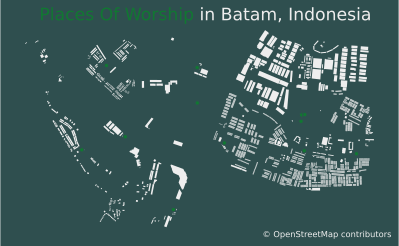

In [11]:
# Get random plot color for points
i = random.randint(0, 8)
c = f"C{i}"

# Construct plot
fig, ax = plt.subplots(figsize=(8,4), facecolor="DarkSlateGray")

# Plot buildings
buildings.geometry.plot(ax=ax, facecolor="#eeeeee", edgecolor="DarkSlateGray", linewidth=0.05)

# Plot most common amenity
common_amenity = piv.sort_values("id", ascending=False).head(1).index.values[0]
idx = amenities.amenity == common_amenity
amenities[idx].plot(ax=ax, zorder=100, edgecolor="DarkSlateGray", linewidth=1, color=c, markersize=20)

# Check for plural case
ending = "s"
if common_amenity[-1] == "s":
    ending = ""
elif common_amenity.endswith("ch") or common_amenity.endswith("sh") or common_amenity[-1] in ["x", "z"]:
    ending = "es"
elif common_amenity == "place_of_worship":
    common_amenity = "places_of_worship"
    ending = ""

# Add title and format
ax.axis('off')
ax.annotate(f"{common_amenity.replace('_', ' ').title()}{ending} ", xy=(0.5,1), xycoords='axes fraction', color=c, ha='right', fontsize="xx-large")
ax.annotate(f"in {city}", xy=(0.5,1), xycoords='axes fraction', color='#eeeeee', ha='left', fontsize="xx-large")

# Add attribution
ax.annotate(f"© OpenStreetMap contributors", xy=(1, 0), xycoords='axes fraction', color="#eeeeee", ha='right', fontsize="small")

# Write to path
out_path = os.path.join("..", "contributions", f"05_{city.split(',').pop(0)}")
fig.savefig(out_path, facecolor="DarkSlateGray", dpi=300)

# Preview
plt.show()